### Descripcion del Proyecto Orientado

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.

- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir si es probable que un nuevo cliente reciba un beneficio de seguro. ¿Puede un modelo de predicción entrenado funcionar mejor que un modelo dummy no entrenado? - ¿Puede funcionar peor? Explica tu respuesta.
- Tarea 3: predecir la cantidad de beneficios de seguro que probablemente recibirá un nuevo cliente utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin romper el modelo de la tarea anterior.

Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento de datos u ofuscación de datos. Pero los datos deben protegerse de tal manera que la calidad de los modelos de machine learning no se vea afectada. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.

Descripción de datos
El dataset se almacena en el archivo /datasets/insurance_us.csv.

- Características:
    - Gender: Sexo.
    - Age: Edad
    - Salary: Salario
    - Family Members: Numero de Familiares
    - Insurance Benefits: Número de familiares de la persona asegurada.
- Objetivo: número de beneficios de seguro recibidos por una persona asegurada en los últimos cinco años.

In [1]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Importación de bibliotecas para machine learning y modelos

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import Ridge
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import PoissonRegressor
from sklearn.dummy import DummyClassifier

# Técnicas de sobremuestreo y submuestreo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


#### Carga los datos.


In [2]:
raw_insurance = pd.read_csv('../datasets/insurance_us.csv')
raw_insurance

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


In [3]:
# Verifica que los datos no tengan problemas: no faltan datos, no hay valores extremos, etc.
raw_insurance.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [4]:
raw_insurance['Age'] = raw_insurance['Age'].astype('int')
raw_insurance['Salary'] = raw_insurance['Salary'].astype('int')
raw_insurance.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Gender              5000 non-null   int64
 1   Age                 5000 non-null   int64
 2   Salary              5000 non-null   int64
 3   Family members      5000 non-null   int64
 4   Insurance benefits  5000 non-null   int64
dtypes: int64(5)
memory usage: 195.4 KB


In [5]:
# Revisamos si tenemos valores duplicados
raw_insurance.duplicated().value_counts()

False    4847
True      153
Name: count, dtype: int64

In [6]:
# Eliminamos los valores duplicados
raw_insurance.drop_duplicates(inplace=True)

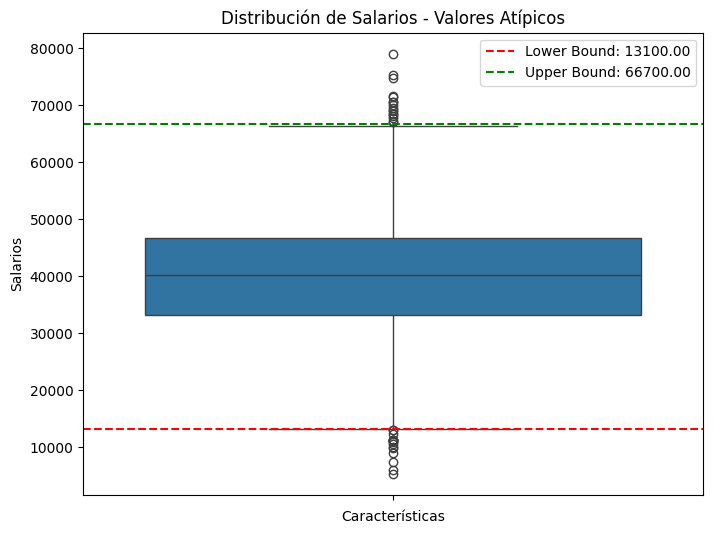

In [7]:
# Valores Atípicos (Outliers) en el salario

# Calculamos los percentiles y el IQR para detectar outliers
Q1 = raw_insurance['Salary'].quantile(0.25)
Q3 = raw_insurance['Salary'].quantile(0.75)
IQR = Q3 - Q1

# Definimos los límites superior e inferior para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Creamos un boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data=raw_insurance['Salary'])

# Añadimos líneas para delimitar los valores atípicos
plt.axhline(y=lower_bound, color='r', linestyle='--', label=f'Lower Bound: {lower_bound:.2f}')
plt.axhline(y=upper_bound, color='g', linestyle='--', label=f'Upper Bound: {upper_bound:.2f}')

# Añadimos título y etiquetas
plt.title('Distribución de Salarios - Valores Atípicos')
plt.xlabel('Características')
plt.ylabel('Salarios')

# Mostramos el gráfico
plt.legend()
plt.show()

#### Comentarios:

- Solo tenemos verdadera variabilidad en los salarios.
- Tenemos valores atipicos, pero considero que es importante mantenerlos para el objetivo del proyecto.

#### Daremos solucion a cada tarea

In [8]:
df_insurance = raw_insurance.reset_index(drop=True)
df_insurance

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41,49600,1,0
1,0,46,38000,1,1
2,0,29,21000,0,0
3,0,21,41700,2,0
4,1,28,26100,0,0
...,...,...,...,...,...
4842,0,28,35700,2,0
4843,0,34,52400,1,0
4844,0,20,33900,2,0
4845,1,22,32700,3,0


#### Tarea 1: Encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.

In [9]:
def find_similar_customers_cosine(df, client_index, top_n=5, weight=2):
    """
    Encuentra los clientes más similares a un cliente de referencia utilizando vecinos cercanos con métrica de distancia coseno.
    
    Parámetros:
    - df: DataFrame con las características escaladas.
    - client_index: Índice del cliente de referencia.
    - top_n: Número de clientes similares a retornar (excluyendo el cliente de referencia).
    - weight: Factor de ponderación para la columna 'Insurance benefits'.
    
    Retorna:
    - similar_indices: Índices de los clientes similares.
    - similar_distances: Distancias coseno correspondientes (menor valor indica mayor similitud).
    """
    # Crear una copia del DataFrame para no modificar el original
    df_weighted = df.copy()
    # Aplicar el peso a la columna "Insurance benefits"
    df_weighted['Insurance benefits'] = df_weighted['Insurance benefits'] * weight
    
    # Instanciar y ajustar el modelo NearestNeighbors con métrica coseno
    nbrs = NearestNeighbors(n_neighbors=top_n+1, metric='cosine')
    nbrs.fit(df_weighted)
    
    # Obtener las distancias y los índices de los vecinos para el cliente de referencia
    distances, indices = nbrs.kneighbors(df_weighted.iloc[[client_index]])
    
    # El primer vecino es el mismo cliente, por lo que se excluye
    similar_indices = indices[0][1:]
    similar_distances = distances[0][1:]
    
    return similar_indices, similar_distances



In [10]:
# Cliente similares segun distancia euclidiana.

client_index = 0

similar_customers, distances_to_similar_customers = find_similar_customers_cosine(df_insurance, client_index)

print("Distancias correspondientes:")
print(distances_to_similar_customers , '\n')

print("Clientes de índice: ", client_index )
print(df_insurance.loc[client_index], '\n')

print("Clientes similares al cliente en el índice 0:")
print(df_insurance.loc[similar_customers])

Distancias correspondientes:
[2.14284146e-12 8.46678283e-12 1.24342758e-11 1.49501522e-11
 1.78352888e-11] 

Clientes de índice:  0
Gender                    1
Age                      41
Salary                49600
Family members            1
Insurance benefits        0
Name: 0, dtype: int64 

Clientes similares al cliente en el índice 0:
      Gender  Age  Salary  Family members  Insurance benefits
3043       1   39   47100               1                   0
2272       1   36   43500               1                   0
2910       1   35   42300               1                   0
2115       1   38   45700               1                   0
4818       1   34   41200               1                   0


#### Tarea 2: Predecir si es probable que un nuevo cliente reciba un beneficio de seguro. ¿Puede un modelo de predicción entrenado funcionar mejor que un modelo dummy no entrenado? ¿Puede funcionar peor?

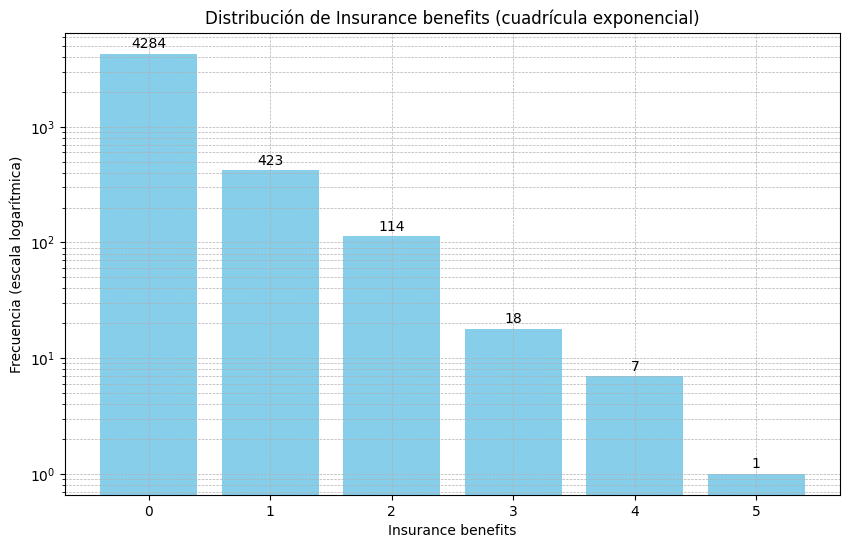

In [11]:
# Revisamos la frecuecia de los registros.

# Calcular el value_counts y ordenar por índice
counts = df_insurance['Insurance benefits'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(counts.index, counts.values, color='skyblue')
plt.yscale('log')  # Establece la escala logarítmica en el eje Y
plt.xlabel('Insurance benefits')
plt.ylabel('Frecuencia (escala logarítmica)')
plt.title('Distribución de Insurance benefits (cuadrícula exponencial)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

# Agregar el valor numérico encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.05, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.show()


[]

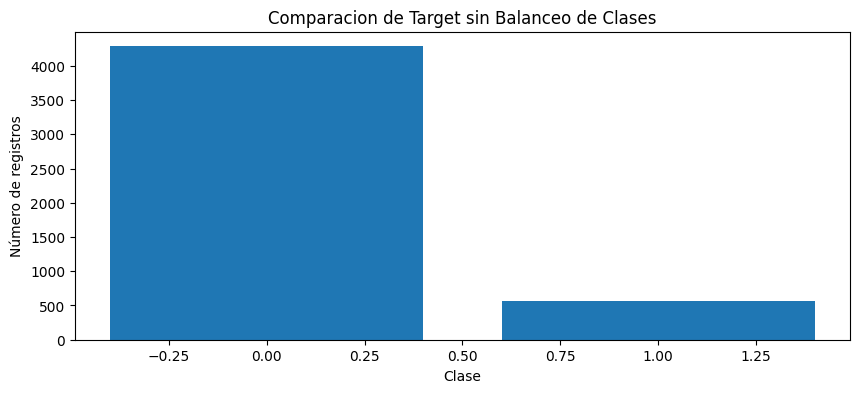

In [12]:
 # Convertimos a 1 si es mayor a 0 : 1 o mas significa que tiene el beneficio.
df_insurance['Insurance benefits_bin'] = (df_insurance['Insurance benefits'] > 0).astype(int)
df_insurance['Insurance benefits_bin'].value_counts() #Con esto vemos un fuerte desbalance

# Visualización de la distribución
plt.figure(figsize=(10,4))
plt.bar([0, 1], np.bincount(df_insurance['Insurance benefits_bin']))
plt.title("Comparacion de Target sin Balanceo de Clases")
plt.xlabel("Clase")
plt.ylabel("Número de registros")
plt.plot()

In [13]:
data_insurance = df_insurance.copy(deep=True)

In [14]:
# Datos de entrenamiento y datos de validacion
features = data_insurance.drop(['Insurance benefits', 'Insurance benefits_bin'], axis=1)
target = data_insurance['Insurance benefits_bin']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=42) # estan ya escalados

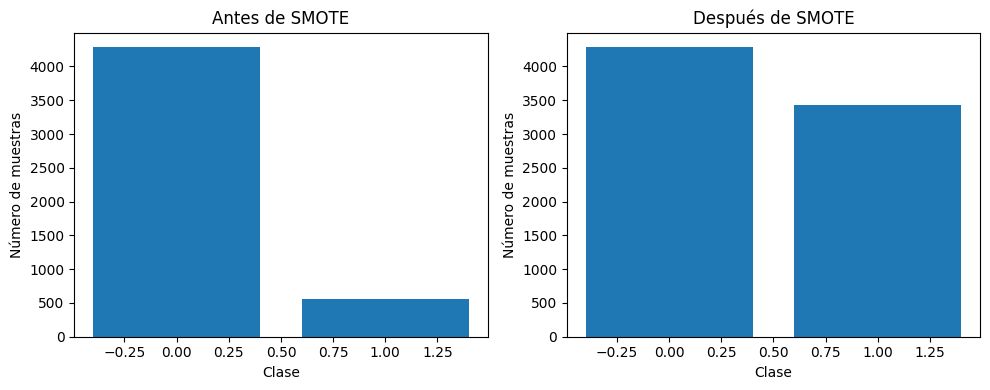

Distribución de clases después del balanceo:
Insurance benefits_bin
0    4284
1    3427
Name: count, dtype: int64


In [15]:
# Estrategia de sobremuestreo: 
# Se usará SMOTE para aumentar la clase minoritaria
smote = SMOTE(sampling_strategy=0.8, random_state=42)
features_smote, target_smote = smote.fit_resample(features, target)

# Visualización de la distribución
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar([0, 1], np.bincount(target))
plt.title("Antes de SMOTE")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")

plt.subplot(1,2,2)
plt.bar([0, 1], np.bincount(target_smote))
plt.title("Después de SMOTE")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()

# Verificar la distribución de clases después del balanceo
print("Distribución de clases después del balanceo:")
print(pd.Series(target_smote).value_counts())

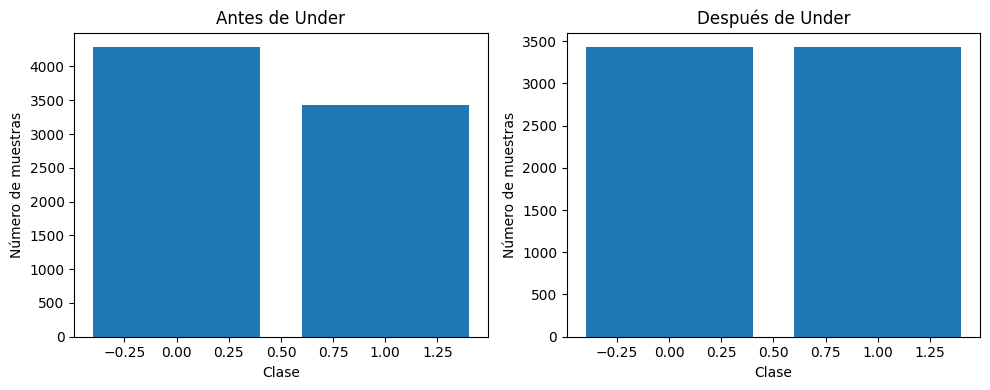

Distribución de clases después del balanceo:
Insurance benefits_bin
0    3427
1    3427
Name: count, dtype: int64


In [16]:
# Estrategia de sobremuestreo: 
# Se usará RandomUnder para disminuir la clase mayoritaria.
under = RandomUnderSampler(sampling_strategy=1, random_state=42)
features_balanced, target_balanced = under.fit_resample(features_smote, target_smote)

# Opcional: Visualización de la distribución
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar([0, 1], np.bincount(target_smote))
plt.title("Antes de Under")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")

plt.subplot(1,2,2)
plt.bar([0, 1], np.bincount(target_balanced))
plt.title("Después de Under")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()

# Verificar la distribución de clases después del balanceo
print("Distribución de clases después del balanceo:")
print(pd.Series(target_balanced).value_counts())

In [17]:
features_train, features_test, target_train, target_test = train_test_split(features_balanced, target_balanced, random_state=42, test_size=0.75)

In [18]:
# Escalar solo las características numéricas
scaler = StandardScaler()
features_train_scaled_2 = scaler.fit_transform(features_train)
features_test_scaled_2 = scaler.transform(features_test)

# Modelo Dummy
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(features_train_scaled_2, target_train)
y_pred_dummy = dummy_model.predict(features_test_scaled_2)
dummy_accuracy = accuracy_score(target_test, y_pred_dummy)
print(f'Precisión del modelo Dummy: {dummy_accuracy:.2f}')

# Modelo de Regresión Logística con más iteraciones
model = LogisticRegression(max_iter=500, solver='lbfgs')  # Aumentamos max_iter
model.fit(features_train_scaled_2, target_train)
y_pred_model = model.predict(features_test_scaled_2)
model_accuracy = accuracy_score(target_test, y_pred_model)
print(f'Precisión del Modelo de Regresión Entrenado: {model_accuracy:.2f}')

Precisión del modelo Dummy: 0.50
Precisión del Modelo de Regresión Entrenado: 0.99


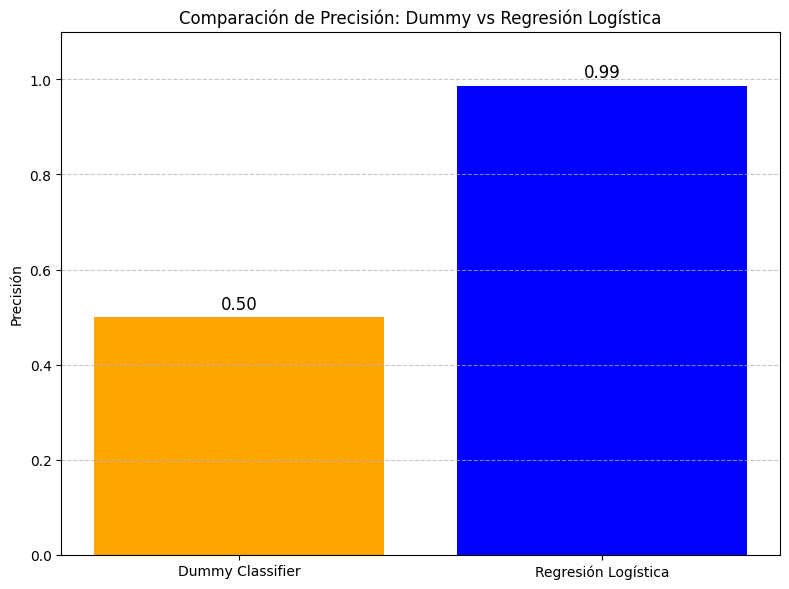

In [19]:
# Supongamos que ya tienes calculadas las precisiones:
# dummy_accuracy: Precisión del modelo Dummy
# model_accuracy: Precisión del modelo de Regresión Logística


# Crear un diccionario con los nombres de los métodos y sus precisiones
resultados = {
    'Dummy Classifier': dummy_accuracy,
    'Regresión Logística': model_accuracy
}

# Extraer las etiquetas y los valores
metodos = list(resultados.keys())
accuracies = list(resultados.values())

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(metodos, accuracies, color=['orange', 'blue'])

# Colocar el valor de cada barra encima de la misma
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1.1)  # Como la precisión está entre 0 y 1
plt.ylabel('Precisión')
plt.title('Comparación de Precisión: Dummy vs Regresión Logística')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Tarea 3: Predecir la cantidad de beneficios de seguro que probablemente recibirá un nuevo cliente utilizando un modelo de regresión lineal.

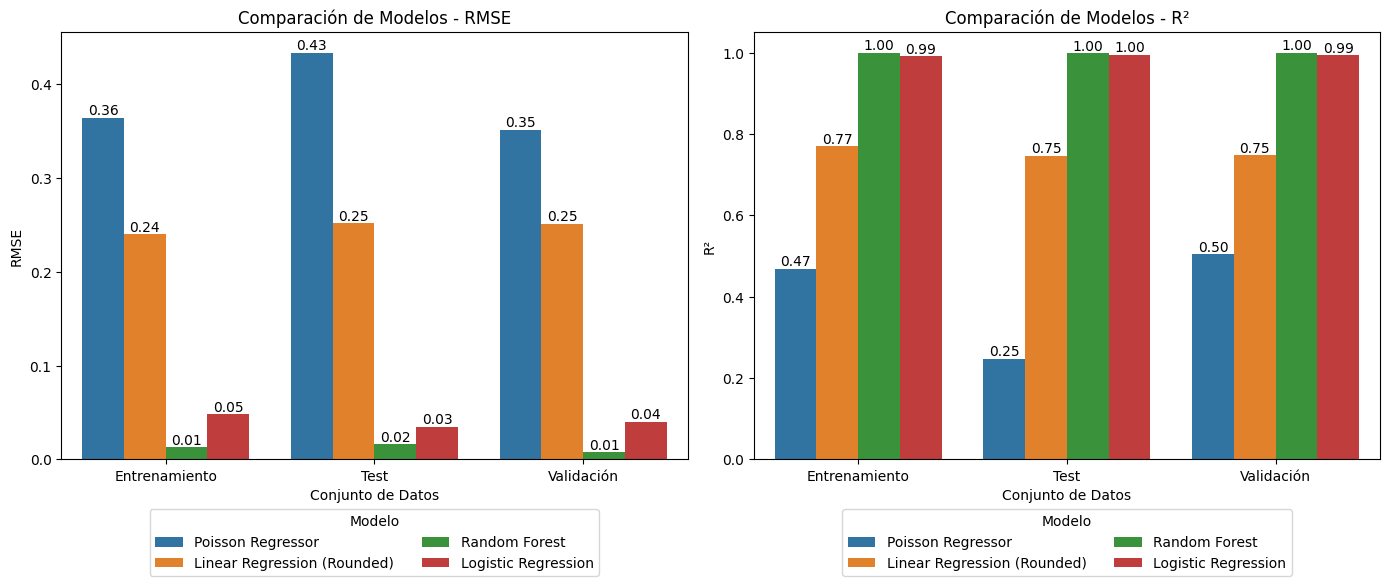

In [20]:
# Función para escalar la columna Salary
def scale_salary(features):
    scaler = StandardScaler()
    features = features.copy()  # Evitar modificar el original
    features['Salary'] = scaler.fit_transform(features[['Salary']])
    return features

# División de los datos
def split_data(features, target):
    features = scale_salary(features)  # Escalar Salary
    features_train, features_review, target_train, target_review = train_test_split(features, target, random_state=42, test_size=0.3)
    features_test, features_valid, target_test, target_valid = train_test_split(features_review, target_review, random_state=42, test_size=0.6)
    return features_train, features_test, features_valid, target_train, target_test, target_valid

# Entrenamiento de modelos y cálculo de métricas
def train_and_evaluate(features_train, features_test, features_valid, target_train, target_test, target_valid):
    models = {
        "Poisson Regressor": PoissonRegressor(),
        "Linear Regression (Rounded)": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=20, random_state=42),
        "Logistic Regression": LogisticRegression(solver="lbfgs", max_iter=1000)
    }

    metrics_rmse = {"Model": [], "Set": [], "RMSE": []}
    metrics_r2 = {"Model": [], "Set": [], "R2": []}

    for model_name, model in models.items():
        model.fit(features_train, target_train)

        # Predicciones
        y_train_pred = model.predict(features_train)
        y_test_pred = model.predict(features_test)
        y_valid_pred = model.predict(features_valid)

        # Para regresión lineal: redondeamos los valores a enteros
        if model_name == "Linear Regression (Rounded)":
            y_train_pred = np.round(y_train_pred).astype(int)
            y_test_pred = np.round(y_test_pred).astype(int)
            y_valid_pred = np.round(y_valid_pred).astype(int)

        # Calcular RMSE
        rmse_train = np.sqrt(mean_squared_error(target_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(target_test, y_test_pred))
        rmse_valid = np.sqrt(mean_squared_error(target_valid, y_valid_pred))

        # Guardar métricas RMSE
        for dataset, rmse in zip(["Entrenamiento", "Test", "Validación"], [rmse_train, rmse_test, rmse_valid]):
            metrics_rmse["Model"].append(model_name)
            metrics_rmse["Set"].append(dataset)
            metrics_rmse["RMSE"].append(rmse)
        
        # Calcular R2
        r2_train = r2_score(target_train, y_train_pred)
        r2_test = r2_score(target_test, y_test_pred)
        r2_valid = r2_score(target_valid, y_valid_pred)

        # Guardar métricas R2
        for dataset, r2 in zip(["Entrenamiento", "Test", "Validación"], [r2_train, r2_test, r2_valid]):
            metrics_r2["Model"].append(model_name)
            metrics_r2["Set"].append(dataset)
            metrics_r2["R2"].append(r2)

    return [pd.DataFrame(metrics_rmse), pd.DataFrame(metrics_r2)]

# Llamado a las funciones
features_train, features_test, features_valid, target_train, target_test, target_valid = split_data(features_balanced, target_balanced)
metrics_df = train_and_evaluate(features_train, features_test, features_valid, target_train, target_test, target_valid)

# Gráficos de comparación con etiquetas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de RMSE
sns.barplot(ax=axes[0], data=metrics_df[0], x="Set", y="RMSE", hue="Model", dodge=True)
axes[0].set_title("Comparación de Modelos - RMSE")
axes[0].set_xlabel("Conjunto de Datos")
axes[0].set_ylabel("RMSE")
axes[0].legend(title="Modelo", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

# Gráfico de R²
sns.barplot(ax=axes[1], data=metrics_df[1], x="Set", y="R2", hue="Model", dodge=True)
axes[1].set_title("Comparación de Modelos - R²")
axes[1].set_xlabel("Conjunto de Datos")
axes[1].set_ylabel("R²")
axes[1].legend(title="Modelo", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

plt.tight_layout()
plt.show()


CONCLUSIONES:

Tarea 3: 
- Para este ejercicio tomamos los datos y escalamos solo los valores de salary ya que presenta enorme variabilidad
- Usando una Poison Regressor tenemos:
    - Entrenamiento: 
        - RMSE = 0.36
        - R2 = 0.47 
    - Prueba: 
        - RMSE = 0.43
        - R2 = 0.25
    - Validacion: 
        - RMSE = 0.35
        - R2 = 0.50
- Usando un Linear Regressor (Rounded) tenemos:
    - Entrenamiento: 
        - RMSE = 0.24
        - R2 = 0.77 
    - Prueba: 
        - RMSE = 0.25
        - R2 = 0.75
    - Validacion: 
        - RMSE = 0.24
        - R2 = 0.75
- Usando un Random Forest Regressor tenemos:
    - Entrenamiento: 
        - RMSE = 0.01
        - R2 = 1
    - Prueba: 
        - RMSE = 0.02
        - R2 = 1
    - Validacion: 
        - RMSE = 0.01
        - R2 = 1
- Usando un Logistic Regression tenemos:
    - Entrenamiento: 
        - RMSE = 0.05
        - R2 = 0.99
    - Prueba: 
        - RMSE = 0.03
        - R2 = 1
    - Validacion: 
        - RMSE = 0.04
        - R2 = 0.99
- Tenemos que Random Forest Regressor tiene mejores metricas con entrenamiento, test y validacion.


#### Tarea 4: Proteger los datos personales de los clientes sin romper el modelo de la tarea anterior.

In [21]:
#Copiamos el dataframe a otra variable para esta tarea
insurance = df_insurance.copy(deep=True)
insurance

,Gender,Age,Salary,Family members,Insurance benefits,Insurance benefits_bin
0,1,41,49600,1,0,0
1,0,46,38000,1,1,1
2,0,29,21000,0,0,0
3,0,21,41700,2,0,0
4,1,28,26100,0,0,0
...,...,...,...,...,...,...
4842,0,28,35700,2,0,0
4843,0,34,52400,1,0,0
4844,0,20,33900,2,0,0
4845,1,22,32700,3,0,0


In [22]:
# Consideraremos que edad 'Age' y salario 'Salary' como datos sensibles

# 1. Enmascarar 'age' (generalización en rangos)
bins = [18, 25, 35, 45, 55, 60, 65]
labels = ['18-25', '26-35', '36-45', '46-55', '56-60', '+61']

insurance['age_group'] = pd.cut(insurance['Age'], bins=bins, labels=labels)
insurance = insurance.drop(columns=['Age'], axis=1)  # Eliminamos la edad exacta

# 2. Enmascarar 'salary' añadiendo ruido controlado

noise_std = 0.05 * insurance['Salary'].std()
noise = np.random.normal(0, noise_std, insurance['Salary'].shape)  # Ruido con desviación estándar 2000
insurance['salary_masked'] = insurance['Salary'] + noise
insurance = insurance.drop(columns=['Salary'],axis=1)  # Eliminamos el salario original
insurance


,Gender,Family members,Insurance benefits,Insurance benefits_bin,age_group,salary_masked
0,1,1,0,0,36-45,49466.855123
1,0,1,1,1,46-55,38184.499485
2,0,0,0,0,26-35,20780.791127
3,0,2,0,0,18-25,41917.594705
4,1,0,0,0,26-35,26431.048700
...,...,...,...,...,...,...
4842,0,2,0,0,26-35,34588.192544
4843,0,1,0,0,26-35,52109.928043
4844,0,2,0,0,18-25,33069.581813
4845,1,3,0,0,18-25,32481.774611


In [23]:
# Codificamos la columna 'age_group' usando One Hot Encoding

# Usamos OneHotEncoder para transformar la columna 'age_group'
# El parámetro sparse_output=False nos asegura que la salida será un array denso (no una matriz dispersa)
encoder = OneHotEncoder(sparse_output=False)  # Cambié 'sparse=False' por 'sparse_output=False' para las versiones más recientes de sklearn
age_group_encoded = encoder.fit_transform(insurance[['age_group']])

# Convertimos el array resultante en un DataFrame
# Utilizamos get_feature_names_out para obtener los nombres de las columnas generadas por la codificación
age_group_encoded_insurance = pd.DataFrame(age_group_encoded, columns=encoder.get_feature_names_out(['age_group']))

# Concatenamos las nuevas columnas codificadas con el DataFrame original
insurance = pd.concat([insurance, age_group_encoded_insurance], axis=1)

# Eliminamos la columna original 'age_group' que ya ha sido codificada
insurance = insurance.drop(columns=['age_group'], axis=1)

# Mostramos el DataFrame final con las columnas codificadas
print(insurance.head())  # Para verificar que la codificación fue exitosa


   Gender  Family members  Insurance benefits  Insurance benefits_bin  \
0       1               1                   0                       0   
1       0               1                   1                       1   
2       0               0                   0                       0   
3       0               2                   0                       0   
4       1               0                   0                       0   

   salary_masked  age_group_+61  age_group_18-25  age_group_26-35  \
0   49466.855123            0.0              0.0              0.0   
1   38184.499485            0.0              0.0              0.0   
2   20780.791127            0.0              0.0              1.0   
3   41917.594705            0.0              1.0              0.0   
4   26431.048700            0.0              0.0              1.0   

   age_group_36-45  age_group_46-55  age_group_56-60  age_group_nan  
0              1.0              0.0              0.0            0.0  
1     

In [24]:
# Dividimos datos en caracteristicas y objetivo
features_4 = insurance.drop(columns=['Insurance benefits'])  # 'Insurance benefits' es el target
# Dividimos datos en caracteristicas y objetivo
target_4 = insurance['Insurance benefits']

features_train, features_valid, target_train, target_valid = train_test_split(features_4, target_4, test_size=0.25, random_state=42)

In [25]:
# Entrenamos el modelo de regresión lineal

# Definimos el modelo de regresión lineal
model = LinearRegression()

# Ajustamos el modelo a los datos de entrenamiento
model.fit(features_train, target_train)

# Realizamos las predicciones sobre el conjunto de validación
y_pred = model.predict(features_valid)

# Evaluamos el rendimiento del modelo calculando el MSE y el R2
mse = mean_squared_error(target_valid, y_pred)  # Calculamos el error cuadrático medio
r2 = r2_score(target_valid, y_pred)  # Calculamos el coeficiente de determinación R2

# Imprimimos las métricas de evaluación
print(f'MSE (Error cuadrático medio): {mse:.2f}')
print(f'R2 (Coeficiente de determinación): {r2:.2f}')


MSE (Error cuadrático medio): 0.02
R2 (Coeficiente de determinación): 0.92


In [26]:
# Entrenamos el modelo RandomForestRegressor con los datos ofuscados

# Definimos el modelo RandomForestRegressor con un valor fijo para random_state para asegurar reproducibilidad
model = RandomForestRegressor(random_state=42)

# Ajustamos el modelo con los datos de entrenamiento
model.fit(features_train, target_train)

# Realizamos las predicciones sobre el conjunto de validación
y_pred = model.predict(features_valid)

# Evaluamos el rendimiento del modelo calculando el MSE (Error cuadrático medio) y el R2 (Coeficiente de determinación)
mse = mean_squared_error(target_valid, y_pred)  # Cálculo del error cuadrático medio
r2 = r2_score(target_valid, y_pred)  # Cálculo del coeficiente de determinación

# Imprimimos los resultados de las métricas de evaluación
print(f'MSE (Error cuadrático medio): {mse:.2f}')
print(f'R2 (Coeficiente de determinación): {r2:.2f}')

MSE (Error cuadrático medio): 0.03
R2 (Coeficiente de determinación): 0.88


### 4. Saca conclusiones basadas en tu experiencia trabajando en el proyecto.

#### CONCLUSIONES
Tarea 1: Búsqueda de clientes similares
- Utilizamos el algoritmo Nearest Neighbors con la métrica 'cosine', lo que nos permite medir la similitud en función del ángulo entre los vectores de características. Esto es útil para encontrar clientes con perfiles similares.
- Implementamos un algoritmo que identifica los 5 clientes más similares a un perfil dado en función de esta métrica.

Tarea 2: Predicción de clientes que recibirán beneficios
- Aplicamos Regresión Logística para identificar a los clientes con mayor probabilidad de recibir un beneficio.
- Transformamos la variable objetivo Insurance benefits en una variable binaria, donde todos los valores mayores a 0 se convirtieron en 1.
- Realizamos escalamiento de datos para optimizar el procesamiento del modelo.
- Aplicamos técnicas de balanceo de clases, ya que los datos estaban desbalanceados.
- Comparamos los resultados de la Regresión Logística con un modelo base (dummy) que asigna etiquetas aleatorias con una precisión de 0.5. Nuestro modelo de Regresión - - 
- Logística alcanzó una precisión del 99%, demostrando su efectividad.

Tarea 3: Comparación de modelos para predicción de Salary
- Escalamos únicamente la variable Salary, ya que presentaba una gran variabilidad en comparación con las demás características.
- Probamos cuatro modelos de regresión para determinar el más óptimo:
- Random Forest Regressor resultó ser el modelo con mejor desempeño, obteniendo los siguientes resultados:
- Entrenamiento:
    - RMSE = 0.01
    - R² = 1.00
- Prueba:
    - RMSE = 0.02
    - R² = 1.00
- Validación:
    - RMSE = 0.01
     - R² = 1.00
- Estos resultados sugieren que el modelo comprende bien las relaciones entre las características y generaliza correctamente. Sin embargo, dado que el max_depth del modelo fue 1, podría existir un riesgo de sobreajuste. No obstante, al comparar los resultados en los conjuntos de prueba y validación, observamos un rendimiento estable, lo que indica que el modelo generaliza adecuadamente.

Tarea 4: Ofuscación de datos y evaluación de impacto
- Aplicamos un método de ofuscación para proteger la información sensible de los clientes:
- Agrupamos la variable Age en rangos de edad.
- Introdujimos ruido controlado en la variable Salary.
- Entrenamos nuevos modelos con los datos enmascarados y utilizamos One-Hot Encoding para procesar las variables categóricas.
- Evaluamos el impacto de la ofuscación comparando los resultados con los datos originales:
- Linear Regression:
    - MSE: 0.02
    - R²: 0.92
- Random Forest Regressor:
    - MSE: 0.03
    - R²: 0.88

- Linear Regression mostró métricas más estables después de la ofuscación, lo que indica que pudo adaptarse mejor a los datos transformados.
Random Forest Regressor, en cambio, se vio más afectado, ya que este modelo depende de relaciones más complejas, las cuales se redujeron debido a la ofuscación.